# Quantifying polymer mixing

In this notebook, we will import a hyperspectral datacube of PiFM spectra of a polymer blend and take a random small sample of the entire cube.

We will also perform non-negative matrix factorization (NMF) on the sampled datacube. We obtain a "W" matrix which contains the coefficients for each polmyer at each pixel, and an "H" matrix which contains the component spectra for each polymer in the blend. For the H matrix, we compute the root mean squared error between the 'ground truth' spectra and the H matrix components.

We utilize the W matrix coefficients to create an image mask that we can subsequently threshold and obtain an image that displays only the pixels that correspond to a certain percentage of one polymer. We can then use region properties to quantify the degree of polymer mixing (roughly).

### Import necessary packages

In [2]:
## Data manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt

## Random numbers for sampling
from random import randint

## Non-negative matrix factorization
from sklearn.decomposition import NMF

### Load hyperspectral data for Polystyrene (PS) and DPPDTT blend

In [3]:
## Set a root directory for data
root_dir = "C:\\Users\\caitl\\Documents\\CHEME599_march2020\\20200506_HyperUnmixing_Data\\"

## Polymer blend image
blend = np.load(root_dir + 'subsample_image_64x64.npy')

## Pure DPPDTT
dppdtt = np.load(root_dir + 'dppdtt_ground_truth.npy')

## Pure PS
ps = np.load(root_dir + 'ps_ground_truth.npy')

### Lets take a slice of the datacube

In [4]:
def sample(image, size):
    """
    creates a subsample of a 3-dimensional image
    Given a 3D image (x, y, z), this function creates a square subsample of a given size (size, size, z). The third dimension is preserved. Depends on Python random `randint` function.
    Parameters
    ------------
    image : Numpy array of 3 dimensions
        The first two dimensions of the array will be sampled/cropped; the third dimension will be preserved
    size : integer
        The size of the sample to be created
    Returns:
    ------------
    sample : Numpy array of 3 dimensions
        Subsample of original image of given size with intact third dimension
    """
    # define x and y dimensions where valid random uppler left corner may be initiated
    valid_range_x = image.shape[0] - size
    valid_range_y = image.shape[1] - size

    # define x and y coordinates of upper left corner of sampled image
    start_x = randint(0, valid_range_x)
    start_y = randint(0, valid_range_y)

    # grab sample out of original image
    sample = image[start_x:start_x + size,
                   start_y:start_y + size, :]

    return sample

### Take a 64x64 sample of the datacube

In [5]:
small_blend = sample(blend, 64)

Let's visualize a couple of slices of this datacube

In [6]:
def Wav_2_Im(image, wn):
    """ 
    Input a 3-dimensional 'image cube' and outputs a normalized slice at one wavenumber.

    Parameters
    ----------
    im : array_like image
         Input data.

    wn : integer
         Integer index value.

    Returns
    ----------
    slice : ndarray
            An image the same size as the input, but only 1 slice in the 3rd dimension.

    Notes
    ----------
    The input image is normalized by individually normalizing each slice in the 3rd dimension. 
    The normalization scheme is (im_slice - minimum of im_slice) / (maximum of im_slice - minimum of im_slice).
    There may be a different way to approach the normalization.

    """

    ## Set up storage for each normalized slice
    normalized = []
    
    ## Set up storage for the entire normalized image
    img_norm = np.empty(image.shape, dtype=np.float32)
    
    ## Loop through each slice in the image and normalize it by: (slice - slice min)/(slice max - slice min)
    for i in np.linspace(0, image.shape[2]-1, image.shape[2]-1).astype(np.int):
    
        ## pull out one slice
        im = image[:,:,i]
    
        ## normalize the slice
        normalized.append((im - np.min(im))/(np.amax(im) - np.min(im)))  

    ## Loop through each slice in the storage array and replace it with the normalized slice
    for i in np.linspace(0, image.shape[2]-1, image.shape[2]-1).astype(np.int):
    
        img_norm[:,:,i] = normalized[i-1]
    
    ## Pull out the normalized image at the wavenumber of interest
    slice = img_norm[:,:,wn-750]
  
    
    return slice

### Visualize a single slice

Text(0.5, 1.0, 'Image at wavenumber=250')

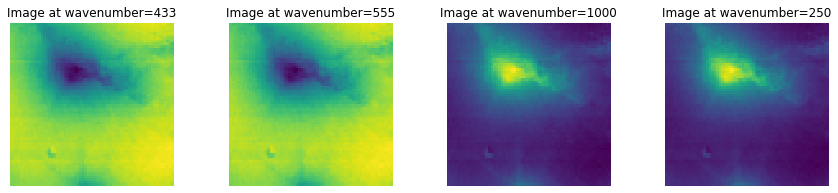

In [7]:
blend_433 = Wav_2_Im(small_blend, 433)
blend_555 = Wav_2_Im(small_blend, 555)
blend_1000 = Wav_2_Im(small_blend, 1000)
blend_250 = Wav_2_Im(small_blend, 250)


figs, axes = plt.subplots(1,4, figsize=(15,3))

for ax in axes:
    ax.axis('off') 
    
axes[0].imshow(blend_433, cmap='viridis')
axes[0].set_title("Image at wavenumber=433")

axes[1].imshow(blend_555, cmap='viridis')
axes[1].set_title("Image at wavenumber=555")

axes[2].imshow(blend_1000, cmap='viridis')
axes[2].set_title("Image at wavenumber=1000")

axes[3].imshow(blend_250, cmap='viridis')
axes[3].set_title("Image at wavenumber=250")

### Perform Non-negative Matrix Factorization on the small image cube

The NMF class comes from scikit-learn and requires a 2D array. This means we first need to flatten the data.

In [8]:
blend_2d = np.zeros((small_blend.shape[0]**2, small_blend.shape[2]))
for i in range(small_blend.shape[2]):
    blend_2d[:,i] = small_blend[:,:,i].flatten()

Now, we can perform the NMF fit function to find the decomposed matrix components. Since this is a blend of two polymers, we should have two matrix components. We need to first initialize the nmf

In [9]:
nmf = NMF(n_components = 2, solver = 'cd', tol = 1e-5, max_iter=int(1e6), l1_ratio = 0.2, alpha = 1e-3, random_state = 0, verbose = False)

We can now fit and transform our image cube using NMF

In [10]:
W_mat = nmf.fit_transform(X = blend_2d + abs(np.min(blend_2d)))
H_mat = nmf.components_

To compare the matrix components to the pure spectra, we need to use a function written by Jessica Kong to baseline correct the spectra. {I need to ask Maddie for Jessica's github repo to credit}

In [11]:
# baseline correction using a function that Jess Kong wrote
import numpy as np
import scipy.linalg as LA
import math

def baseline(y, deg=3, max_it=100, tol=1e-3):
    """Computes the baseline of a given data.
    Iteratively performs a polynomial fitting in the data to detect its
    baseline. At every iteration, the fitting weights on the regions with
    peaks are reduced to identify the baseline only.
    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges.
    max_it : int
        Maximum number of iterations to perform.
    tol : float
        Tolerance to use when comparing the difference between the current
        fit coefficient and the ones from the last iteration. The iteration
        procedure will stop when the difference between them is lower than
        *tol*.
    Returns
    -------
    ndarray
        Array with the baseline amplitude for every original point in *y*
    """
    order = deg + 1
    coeffs = np.ones(order)

    # try to avoid numerical issues
    cond = math.pow(y.max(), 1. / order)
    x = np.linspace(0., cond, y.size)
    base = y.copy()

    vander = np.vander(x, order)
    vander_pinv = LA.pinv2(vander)

    for _ in range(max_it):
        coeffs_new = np.dot(vander_pinv, y)

        if LA.norm(coeffs_new - coeffs) / LA.norm(coeffs) < tol:
            break

        coeffs = coeffs_new
        base = np.dot(vander, coeffs)
        y = np.minimum(y, base)

    return base

In [12]:
for i in range(H_mat.shape[0]):
    base_i = baseline(H_mat[i,:])
    H_mat[i,:] = H_mat[i,:] - base_i
    
print(H_mat.shape)

(2, 1128)


Lets visualize the component spectra

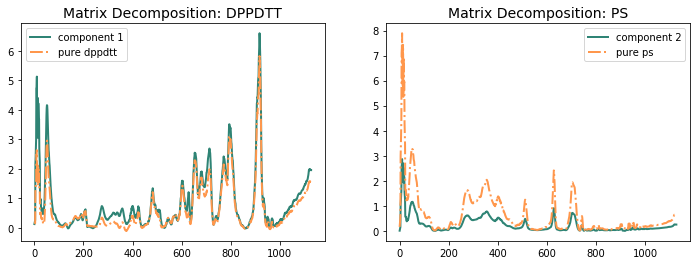

In [13]:
X = np.linspace(0, len(H_mat[0]), 1128)
figs, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(X, H_mat[0], lw=2, linestyle='-', color="#2F8475", label='component 1')
axes[0].plot(X, dppdtt, lw=2, linestyle='-.', color="#FF974C", label='pure dppdtt')
axes[0].set_title("Matrix Decomposition: DPPDTT", fontsize=14)
axes[0].legend()

axes[1].plot(X, H_mat[1], lw=2, linestyle='-', color="#2F8475", label='component 2')
axes[1].plot(X, ps, lw=2, linestyle='-.', color="#FF974C", label='pure ps')
axes[1].set_title("Matrix Decomposition: PS", fontsize=14)
axes[1].legend()

### Now, lets look at the coefficient images from the W matrix

First, we need to reshape the W matrix into a 64x64 pixel image with two sets of coefficients

In [14]:
coeffs = W_mat.reshape(64,64,2) 

Text(0.5, 1.0, 'Coefficients of PS')

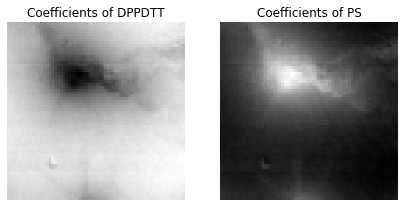

In [15]:
figs, axes = plt.subplots(ncols=2, figsize=(7, 5))

for ax in axes:
    ax.axis('off')

axes[0].imshow(coeffs[:,:,0], cmap='gray')
axes[0].set_title('Coefficients of DPPDTT')

axes[1].imshow(coeffs[:,:,1], cmap='gray')
axes[1].set_title('Coefficients of PS')

Normalize the coefficients relative to DPPDTT

In [16]:
threshold_mat = np.zeros_like(coeffs[:,:,0])

dppdtt_co = coeffs[:,:,0]
ps_co = coeffs[:,:,1]

In [17]:
for i in range(threshold_mat.shape[0]):
    for j in range(threshold_mat.shape[1]):
        threshold_mat[i][j] = dppdtt_co[i][j]/(dppdtt_co[i][j] + ps_co[i][j])

Save the threshold image to use later

In [22]:
np.save('normalized_im', threshold_mat)

Display the normalized coefficient image

Text(0.5, 1.0, 'Normalized Image of Coefficients')

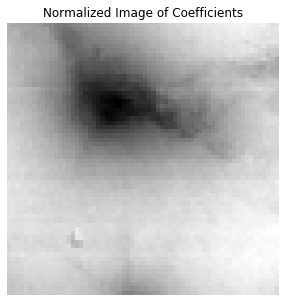

In [19]:
figs, axes = plt.subplots(figsize=(5,5))

axes.axis('off')
axes.imshow(threshold_mat, cmap='gray')
axes.set_title('Normalized Image of Coefficients')


### Create threshold mask 

In [157]:
mask = np.zeros_like(threshold_mat)

In [153]:
mask_2 = np.zeros((threshold_mat.shape[0], threshold_mat.shape[1], 10))
mask_2.shape

(64, 64, 10)

In [133]:
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if threshold_mat[i][j] >= 0.5:
            mask[i][j] = 1
        else:
            mask[i][j] = 0

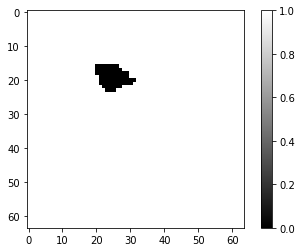

In [134]:
plt.imshow(mask, cmap='gray')
plt.colorbar()

This shows that only one small corner is greater than 95% DPPDTT!

### Mask the image

Text(0.5, 1.0, 'Mask Overlayed')

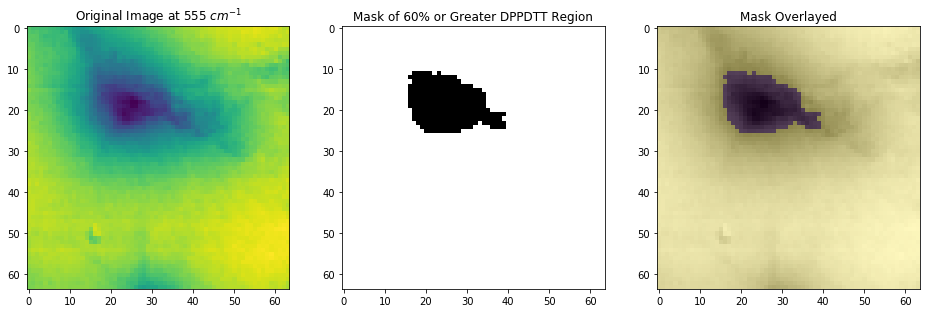

In [29]:
fig, ax = plt.subplots(ncols = 3, figsize = (16,5))

ax[0].imshow(blend_555) # indexed from 0 but wavenumbers range from 750 to 1878
ax[0].set_title('Original Image at 555 $cm^{-1}$')

ax[1].imshow(mask, cmap = 'gray')
ax[1].set_title('Mask of 60% or Greater DPPDTT Region')

ax[2].imshow(blend_555, cmap = 'gray')
ax[2].imshow(mask, alpha = 0.3)
ax[2].set_title('Mask Overlayed')

### Now that we have a binary mask, we can calculate some properties of the image

In [45]:
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
from skimage.color import label2rgb

Text(0.5, 1.0, 'Labeled Image')

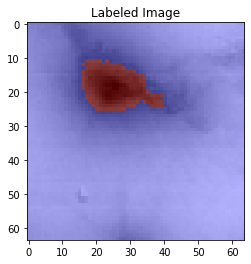

In [31]:
labels = label(mask)
image_label_overlay = label2rgb(labels, image=blend_555)
plt.imshow(image_label_overlay)
plt.title('Labeled Image')

Get the properties of the regions

In [32]:
props = ('area', 'major_axis_length', 'minor_axis_length', 'mean_intensity')
regions = pd.DataFrame(regionprops_table(labels, blend_555, props))
print(regions)

   area  major_axis_length  minor_axis_length  mean_intensity
0  3845          76.095307           74.59013        0.773246


Calculate the area fraction of greater than 95% DPPDTT to the total image area

In [33]:
area_frac = regions['area'].values / 64**2
print("area fraction = ", np.round(area_frac*100, 2))

area fraction =  [93.87]


### Create a function to calculate the area fraction at each percentage of DPPDTT, in steps of 5%

In [249]:
def AreaFraction(im, norm_im, image_size):
    '''This function takes an image, the normalized image, and the size of the image and
    creates a threshold mask of the image, labels regions of interest, and computes the
    region properties. It then computes the fraction of the total image that is a certain 
    percentage (or higher) of a polymer component.
    
    Parameters
    -----------------   
    im : ndarray.
    Original image to process.
        
    norm_im : ndarray.
    Image of NMF coefficients, normalized to be less than 1.
              
    image_size : int.
    Size of the total image. 
   
    Returns
    ----------------
    regions : dict.
    Dictionary of regions of interest and their computed properties.

    mask : ndarray.
    Multidimensional array with each binarized image.
          
    area_frac : list.
    List of computed area fractions of DPPDTT. '''
    
    ## Set up an array of threshold values
    percents = np.round(np.arange(0.5, 1.0, 0.05),2)
    
    ## Create a multidimensional array to store each of the thresholded images. 
    ## In this case, there are ten different tested percentages
    mask = np.zeros((norm_im.shape[0], norm_im.shape[1], 10))

    for h in range(mask.shape[2]):
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if norm_im[i][j] >= percents[h]:
                    mask[i][j][h] = 1
                else:
                    mask[i][j][h] = 0
       
            
    ## Loop through the masks and compute labels and region properties
    regions = {}
    props = ('area', 'major_axis_length', 'minor_axis_length', 'mean_intensity')
    
    for i in range(mask.shape[2]):
        labels = label(mask[:,:,i])
        regions[i] = pd.DataFrame(regionprops_table(labels, im, props))
    
    ## Compute the area fractions
    area_frac = []
    for i in range(len(regions.keys())):
        area_frac.append(regions[i]['area'].values / image_size**2)
        
    return regions, mask, area_frac
    

### Compute the area fractions at each threshold value

In [263]:
props, ims, fracs = AreaFraction(blend_555, threshold_mat, 64)

Lets plot the change in area fraction of percentage threshold

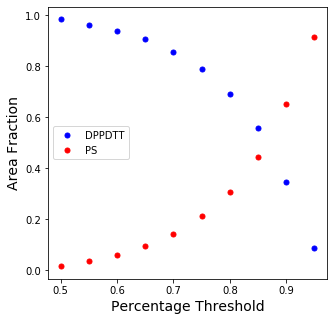

In [281]:
sum_fracs = []
for i in range(len(fracs)):
    sum_fracs.append(np.sum(fracs[i]))

figs, axes = plt.subplots( figsize=(5,5))
percents = np.round(np.arange(0.5, 1.0, 0.05),2)

axes.plot(percents, np.array(sum_fracs), linestyle="None", marker="o", markersize=5, color='b', label="DPPDTT")
axes.plot(percents, 1-np.array(sum_fracs), linestyle="None", marker="o", markersize=5, color='r', label="PS")
axes.set_ylabel('Area Fraction', fontsize=14)
axes.set_xlabel('Percentage Threshold', fontsize=14)
axes.legend()



For kicks, lets display all of the binarized images

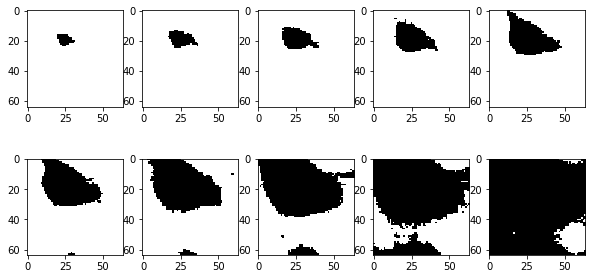

In [279]:
figs, axes = plt.subplots(2,5, figsize=(10,5))

axes[0,0].imshow(ims[:,:,0], cmap='gray')
axes[0,1].imshow(ims[:,:,1], cmap='gray')
axes[0,2].imshow(ims[:,:,2], cmap='gray')
axes[0,3].imshow(ims[:,:,3], cmap='gray')
axes[0,4].imshow(ims[:,:,4], cmap='gray')
axes[1,0].imshow(ims[:,:,5], cmap='gray')
axes[1,1].imshow(ims[:,:,6], cmap='gray')
axes[1,2].imshow(ims[:,:,7], cmap='gray')
axes[1,3].imshow(ims[:,:,8], cmap='gray')
axes[1,4].imshow(ims[:,:,9], cmap='gray')